In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/kundu/Downloads/E-Commerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()


Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [2]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Establish connection to MySQL database
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='1234',
    database='ecommerce'
)

# Create a cursor object to interact with the database
cur = db.cursor()


# List all the unique cities where customers are located


In [3]:
querry = """select distinct(upper(customer_city))from customers"""
cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data)
df
      

,0
0,FRANCA
1,SAO BERNARDO DO CAMPO
2,SAO PAULO
3,MOGI DAS CRUZES
4,CAMPINAS
...,...
4114,SIRIJI
4115,NATIVIDADE DA SERRA
4116,MONTE BONITO
4117,SAO RAFAEL


# Count the numbers of orders placed in 2017

In [4]:
querry = """select count(order_id) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(querry)
data = cur.fetchall()
data

[(45101,)]

# Find the total sales for Category

In [5]:
querry = """select upper(products.product_category) category,round(sum(payments.payment_value),2) sales
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc """

cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Category", "Sales"])
df
            

,Category,Sales
0,BED TABLE BATH,1712553.67
1,HEALTH BEAUTY,1657373.12
2,COMPUTER ACCESSORIES,1585330.45
3,FURNITURE DECORATION,1430176.39
4,WATCHES PRESENT,1429216.68
...,...,...
69,PC GAMER,2174.43
70,HOUSE COMFORT 2,1710.54
71,CDS MUSIC DVDS,1199.43
72,FASHION CHILDREN'S CLOTHING,785.67


# Calcuate the percentage of orders that were paid in installments.

In [6]:
querry = """select sum(case when payment_installments >= 1 then 1
else 0 end)/count(*)*100 from payments"""

cur.execute(querry)
data = cur.fetchall()
data

[(Decimal('99.9981'),)]

# Count the number of customers from each state

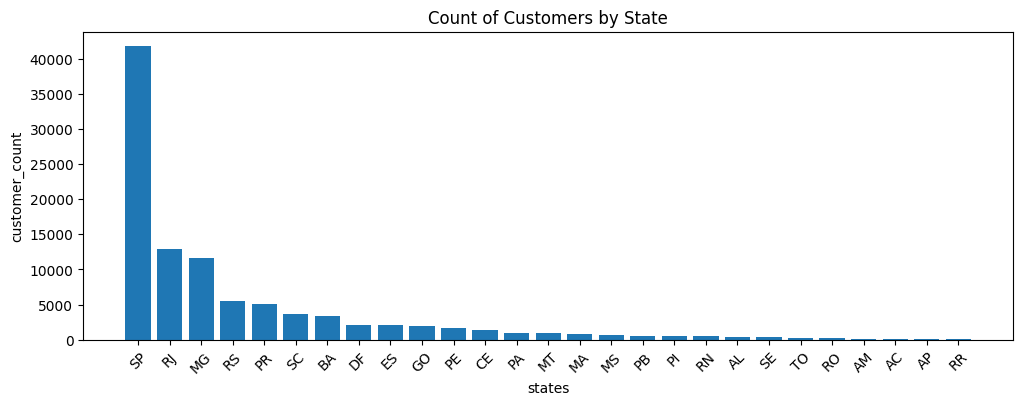

In [7]:
querry = """select customer_state,count(customer_id) from customers
group by customer_state"""

cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["state", "customer_count"])
df = df.sort_values(by = "customer_count", ascending = False)

plt.figure(figsize = (12,4))
plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 45)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by State")
plt.show()

# Calulate the umber of orders per month in 2018

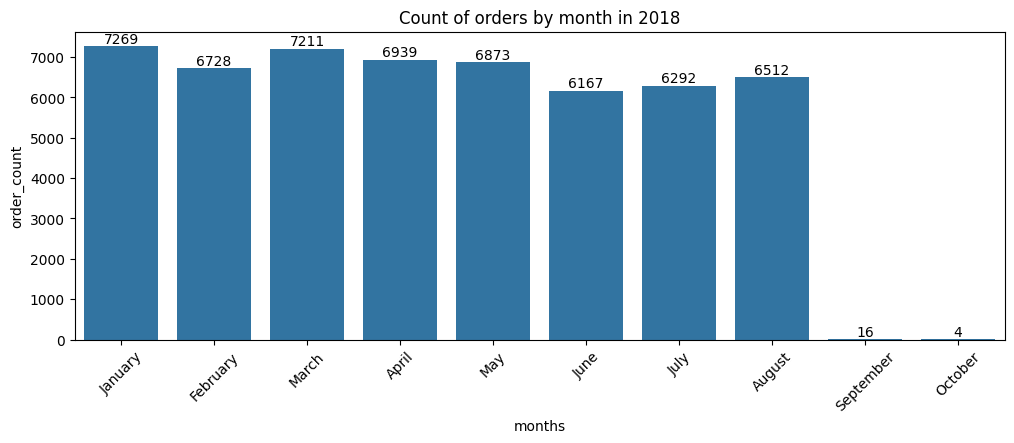

In [8]:
querry = """select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months"""

cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["months", "order_count"])
df
o = ["January","February","March","April","May","June","July","August","September","October"]
plt.figure(figsize = (12,4))
ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df,order = o)
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of orders by month in 2018")
plt.show()


# Find the average number of products per order, grouped by customer city.

In [9]:
querry = """with count_per_order as (select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc;"""

cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Customer city", "Average products/orders"])
df


,Customer city,Average products/orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
...,...,...
4105,lagoa da canoa,1.00
4106,japaratuba,1.00
4107,sebastiao leal,1.00
4108,morro agudo de goias,1.00


# Calculate the percentage of total revenue contributed by each product category.

In [10]:
querry = """select upper(products.product_category) category,
round((sum(payments.payment_value)/(select sum(payment_value) from payments))* 100,2) sales_percentage
from products join order_items
on products.product_id = order_items.product_id
join payments
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""

cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Product category", "Sales Percentage"])
df


,Product category,Sales Percentage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
...,...,...
69,HOUSE COMFORT 2,0.01
70,CDS MUSIC DVDS,0.01
71,PC GAMER,0.01
72,FASHION CHILDREN'S CLOTHING,0.00


# Identify the correlation between product price and the number of times a product has been purchased.

In [11]:
querry = """select products.product_category,
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Product category", "order_count", "price"])

arr1 = df["order_count"]
arr2 = df["price"]

np.corrcoef([arr1,arr2])


array([[ 1.        , -0.10631514],
       [-0.10631514,  1.        ]])

# Calculate the total revenue generated by each seller, and rank them by revenue

In [18]:
querry = """select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(querry)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["Seller id","Revenue","Rank"])
df



,Seller id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.907302,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.039840,2
2,4a3ca9315b744ce9f8e9374361493884,301245.269765,3
3,1f50f920176fa81dab994f9023523100,290253.420128,4
4,53243585a1d6dc2643021fd1853d8905,284903.080498,5
...,...,...,...
3090,ad14615bdd492b01b0d97922e87cb87f,19.209999,3082
3091,702835e4b785b67a084280efca355756,18.559999,3083
3092,4965a7002cca77301c82d3f91b82e1a9,16.360001,3084
3093,77128dec4bec4878c37ab7d6169d6f26,15.220000,3085


# Calculate the moving average of order values for each customer over their order hisory.

In [21]:
querry = """select customer_id, order_purchase_timestamp,payment,
avg(payment) over (partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id,orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a; """

cur.execute(querry)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["customer id","Time stamp","Price","Moving avg"])
df


,customer id,Time stamp,Price,Moving avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.120001
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.130001
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.130005
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000


# Calculate the cumulative sales per month for each year.

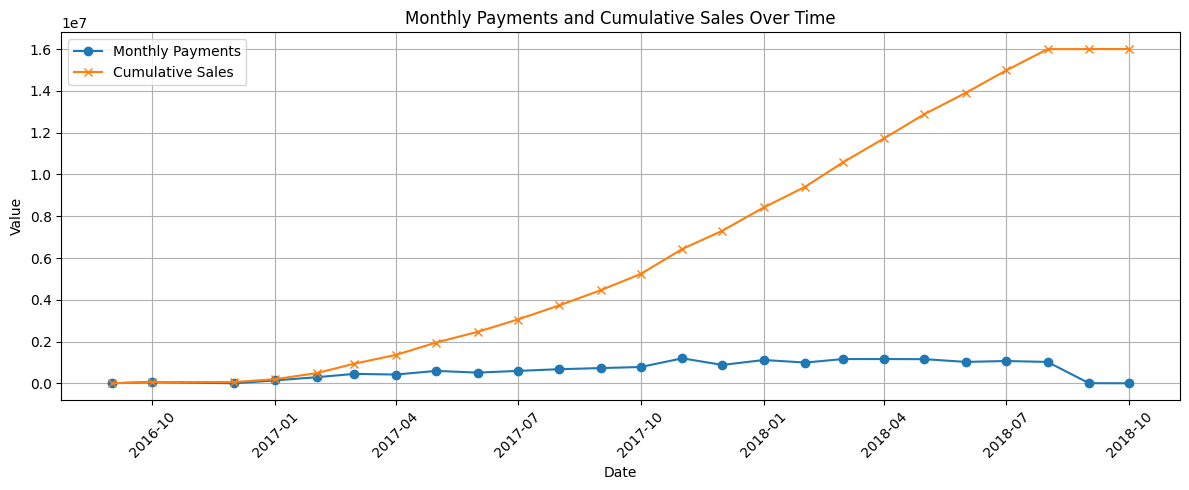

In [29]:

querry = """
SELECT 
    years AS Years, 
    months AS Months, 
    payment AS Payments, 
    SUM(payment) OVER (ORDER BY years, months) AS Cumulative_Sales 
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        MONTH(orders.order_purchase_timestamp) AS months,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        years, months 
    ORDER BY 
        years, months
) AS a;
"""

# Execute the query
cur.execute(querry)
data = cur.fetchall()

# Create a DataFrame from the fetched data
df = pd.DataFrame(data, columns=["Years", "Months", "Payments", "Cumulative_Sales"])

# Convert 'Years' and 'Months' into a single datetime column for easier plotting
# Ensure month is zero-padded for proper date formatting
df['Date'] = pd.to_datetime(df['Years'].astype(str) + df['Months'].apply(lambda x: f'{x:02d}') + '01', format='%Y%m%d')

# Plotting
plt.figure(figsize=(12, 5))
plt.plot(df['Date'], df['Payments'], label='Monthly Payments', marker='o')
plt.plot(df['Date'], df['Cumulative_Sales'], label='Cumulative Sales', marker='x')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Monthly Payments and Cumulative Sales Over Time')
plt.legend()
plt.grid(True)

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Calculate the year-over-year growth rate of total sales.

In [30]:
querry = """with a as (SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        ROUND(SUM(payments.payment_value), 2) AS payment 
    FROM 
        orders 
    JOIN 
        payments ON orders.order_id = payments.order_id
    GROUP BY 
        years
    ORDER BY 
        years)
        select years,((payment -lag(payment, 1) over(order by years))/lag(payment, 1) over(order by years)) * 100 from a """

cur.execute(querry)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns = ["Years","YOY growth %"])
df


,Years,YOY growth %
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase

In [31]:
querry = """with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.order_id
group by customer_id),

 b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp <
date_add(first_order, interval 6 month)
group by a.customer_id)

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""

cur.execute(querry)
data = cur.fetchall()
data

# Since there is no repeated customer within 6 month, hence it's showing "None"

[(None,)]

# Identify top 3 customers who spent the most money in each year.

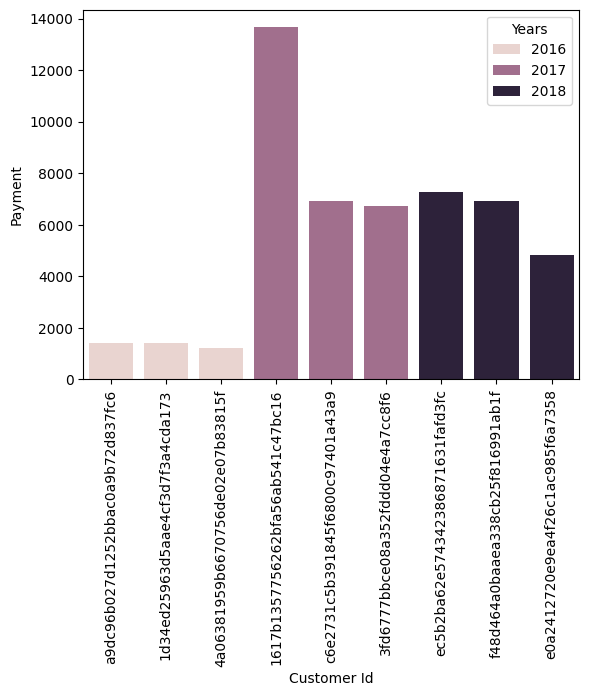

In [45]:
querry = """SELECT 
    years,
    customer_id,
    payment,
    d_rank
FROM (
    SELECT 
        YEAR(orders.order_purchase_timestamp) AS years,
        orders.customer_id,
        SUM(payments.payment_value) AS payment,
        DENSE_RANK() OVER (
            PARTITION BY YEAR(orders.order_purchase_timestamp)
            ORDER BY SUM(payments.payment_value) DESC
        ) AS d_rank
    FROM 
        orders 
    JOIN 
        payments ON payments.order_id = orders.order_id
    GROUP BY 
        YEAR(orders.order_purchase_timestamp),
        orders.customer_id
) AS a
WHERE d_rank <= 3;
"""

cur.execute(querry)
data = cur.fetchall()
data
df = pd.DataFrame(data, columns = ["Years","Customer Id","Payment","D_Rank"])

sns.barplot(x = "Customer Id", y ="Payment", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.show()
